In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)

        self.dropout1 = nn.Dropout(0.25) 
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    images, labels = next(iter(test_loader))
    output1 = model(images)
    pred1 = output1.argmax(dim=1, keepdim=True)

In [5]:
def show_(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))

    with torch.no_grad():
        output1 = model(images)

    pred1 = output1.argmax(dim=1, keepdim=True)

    for i in range(9):
        print(f"GT #{i+1}: {labels[i].item()} | Prediction #{i+1}: {pred1[i].item()}")

        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].cpu().numpy().squeeze(), cmap="gray")
        plt.title(f"GT: {labels[i].item()} | Pred: {pred1[i].item()}", fontsize=10)
        plt.axis("off")
    
    plt.show()

In [6]:
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=4, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')

    args = parser.parse_args(['--batch-size', '64', '--test-batch-size', '1000', '--epochs', '1', '--lr', '1.0', '--gamma', '0.7'])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device) 
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        show_(model,  test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308479
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.590655
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.790749
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.657724
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.350074
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.369764
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.348133
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.391021
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.366617
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.277427
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.152517
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.243094
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.349941
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.133925
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.200861
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.119459
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.524526
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.160262
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.468837
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.116855
Train Epoch: 1 [12800/60000 (

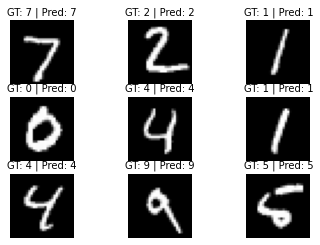

In [24]:
if __name__ == '__main__':
    main()

# Task 1: CIFAR 10

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

100%|████████████████████████████████████████████████████████████████| 170498071/170498071 [03:26<00:00, 824253.40it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


# Start of the model

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

# parameters: Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)        
# charactersitics: 60000 32x32        
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)

        self.dropout1 = nn.Dropout(0.25) 
        self.dropout2 = nn.Dropout(0.5)
# 32 -> 16 -> 8
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        return output

In [32]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

In [33]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    images, labels = next(iter(test_loader))
    output1 = model(images)
    pred1 = output1.argmax(dim=1, keepdim=True)

In [69]:
def show_(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))

    with torch.no_grad():
        output1 = model(images)

    pred1 = output1.argmax(dim=1, keepdim=True)

    for i in range(9):
        print(f"GT #{i+1}: {labels[i].item()} | Prediction #{i+1}: {pred1[i].item()}")
        
# .reshape(32,32,3). images.reshape()
# .T        
# np.transpose (1, 2, 0)     
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].cpu().numpy().T.squeeze().reshape(32,32,3), cmap="gray")
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f"GT: {labels[i].item()} | Pred: {pred1[i].item()}", fontsize=10)
        plt.axis("off")
    
    plt.show()

In [70]:
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='TorchVision CIFAR10 Example')
    parser.add_argument('--batch-size', type=int, default=4, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')

    args = parser.parse_args(['--batch-size', '64', '--test-batch-size', '1000', '--epochs', '1', '--lr', '1.0', '--gamma', '0.7'])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    # if use_cuda:
    #     device = torch.device("cuda")
    # elif use_mps:
    #     device = torch.device("mps")
    device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])

    dataset1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                       transform=transform)
    dataset2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                       transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device) 
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        show_(model,  test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "CIFAR10_cnn.pt")

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.306554
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.297998
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.300219
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.332988
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.219170
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.196541
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.196548
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.242943
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.078732
Train Epoch: 1 [5760/50000 (12%)]	Loss: 2.149945
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.909985
Train Epoch: 1 [7040/50000 (14%)]	Loss: 1.918373
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.022701
Train Epoch: 1 [8320/50000 (17%)]	Loss: 2.103451
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.845189
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.072267
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.731654
Train Epoch: 1 [10880/50000 (22%)]	Loss: 1.860479
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.833301
Tr

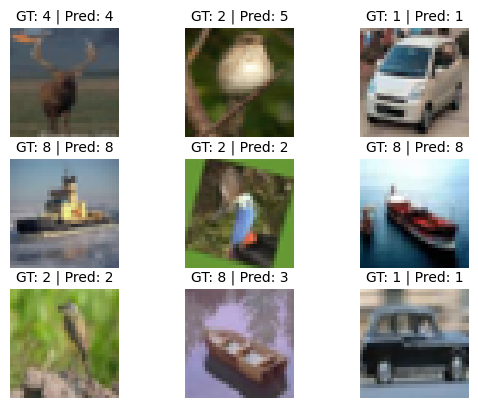

In [71]:
if __name__ == '__main__':
    main()